# ODE/FBA BioSimulators Composite

In [1]:
import sys, os
# get the path to the notebook, and change working directory
notebook_path = sys.path[0][:sys.path[0].index('notebooks')]
sys.path.append(notebook_path)
os.chdir(sys.path[-1])

In [28]:
from biosimulators_utils.sedml.data_model import ModelLanguage
from vivarium.core.engine import Engine, pf
from vivarium.core.composer import Composite
from vivarium.plots.topology import plot_topology
from vivarium.plots.simulation_output import plot_simulation_output
from vivarium_biosimulators.library.mappings import tellurium_mapping
from vivarium_biosimulators.processes.biosimulator_process import BiosimulatorProcess
from vivarium_biosimulators.library.mappings import remove_multi_update
from vivarium_biosimulators.models.model_paths import MILLARD2016_PATH, BIGG_iAF1260b_PATH
import warnings; warnings.filterwarnings('ignore')

BIGG_MODEL_PATH = BIGG_iAF1260b_PATH
SBML_MODEL_PATH = MILLARD2016_PATH
TIME_STEP = 1

FLUX_TO_BOUNDS_MAP = {
    'GLCp': 'R_EX_glc__D_e_upper_bound',
}

## Tellurium Process

### Generate a BioSimulators-Tellurium Vivarium process

In [5]:
# set up configuration
ode_config = {
    'biosimulator_api': 'biosimulators_tellurium',
    'model_source': SBML_MODEL_PATH,
    'model_language': ModelLanguage.SBML.value,
    'simulation': 'uniform_time_course',
    'emit_ports': ['concentrations', 'outputs'],
    'time_step': TIME_STEP,
}

# make the process
ode_process = BiosimulatorProcess(ode_config)

### Generate a Tellurium composite
Composites have a topology, which allows us to connect the tellurium processes' initial state to outputs variables

In [8]:
ode_composite = Composite({
    'processes': {
        'ode': ode_process
    },
    'topology': {
        'ode': {
            'outputs': ('state',),
            'inputs': ('state',),
        }
    }
})

### Plot Tellurium topology

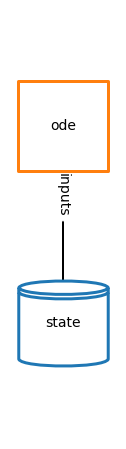

In [21]:
settings = {
    'buffer': 1.0
}
tellurium_topology = plot_topology(ode_composite, settings)

### Run a simulation

In [10]:
total_time = 30.

# get initial state from composite
ode_initial_state = ode_composite.initial_state()
ode_initial_state = remove_multi_update(ode_initial_state)

# make an experiment
ode_experiment = Engine(
    processes=ode_composite.processes,
    topology=ode_composite.topology,
    initial_state=ode_initial_state,
)
# run the simulation
ode_experiment.update(total_time)


Simulation ID: 26bab340-295f-11ec-8397-8c85908ac627
Created: 10/09/2021 at 17:15:19
Completed in 0.084310 seconds


### Plot simulation output

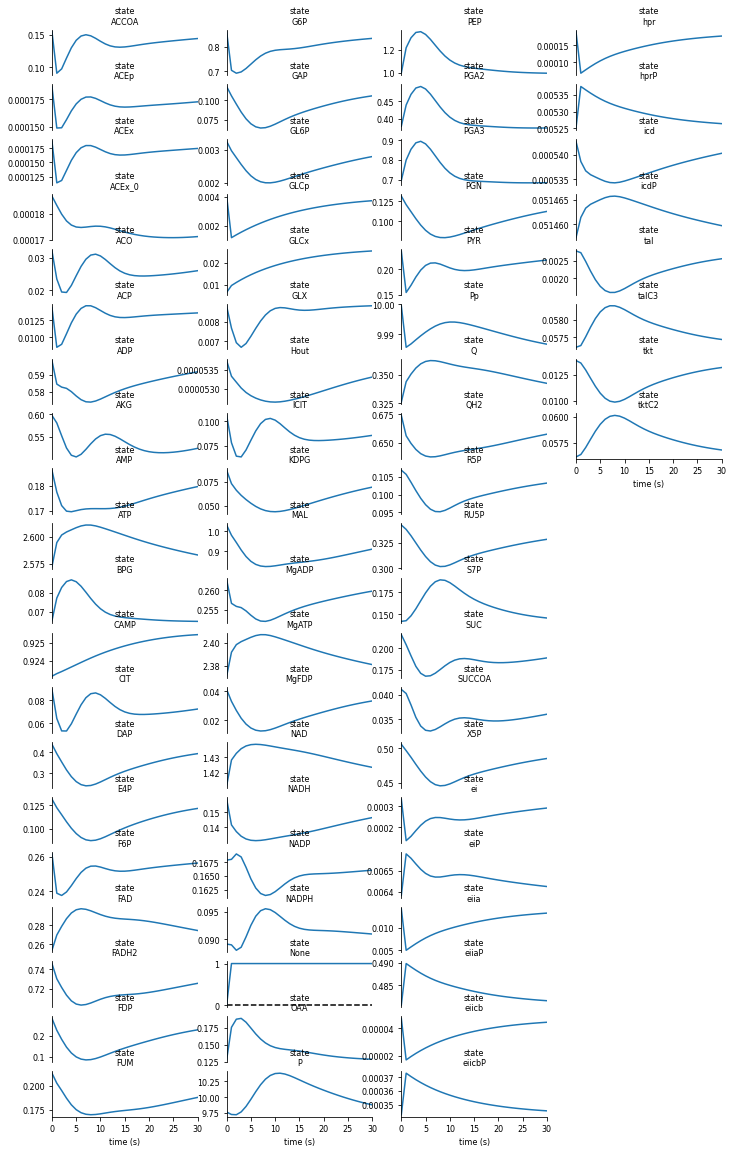

In [11]:
# get the data
ode_output = ode_experiment.emitter.get_timeseries()

settings = {'max_rows': 20}
fig = plot_simulation_output(ode_output, settings)

## COBRApy process

### Generate a BioSimulators-COBRApy Vivarium process

In [12]:
fba_config = {
    'biosimulator_api': 'biosimulators_cobrapy',
    'model_source': BIGG_MODEL_PATH,
    'model_language': ModelLanguage.SBML.value,
    'simulation': 'steady_state',
    'algorithm': {
        'kisao_id': 'KISAO_0000437',
    }
}
fba_process = BiosimulatorProcess(fba_config)

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


### Generate a COBRApy composite
Add a `Clock` Process that controls time, since COBRA is a deriver and would only run once on its own.

In [17]:
from vivarium.processes.clock import Clock
clock = Clock()

# make a composite
fba_composite = Composite({
    'processes': {
        'cobrapy': fba_process,
        'clock': clock
    },
    'topology': {
        'cobrapy': {
            'outputs': ('state',),
            'inputs': ('state',),
        },
        'clock': {
            'global_time': ('global_time',)
        }
    }
})

### Plot COBRA-Clock topology

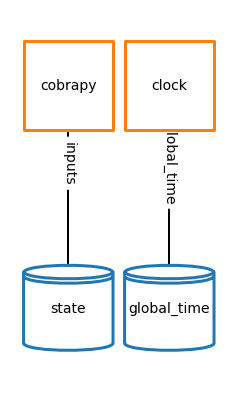

In [18]:
settings = {}
fba_topology = plot_topology(fba_composite, settings)

### Run a simulation

In [25]:
total_time = 2.

# get initial state from composite
fba_initial_state = fba_composite.initial_state()
fba_initial_state = remove_multi_update(fba_initial_state)

# make an experiment
fba_experiment = Engine(
    processes=fba_composite.processes,
    topology=fba_composite.topology,
    initial_state=fba_initial_state,
)
# run the simulation
fba_experiment.update(total_time)


Simulation ID: 8f6a3cda-295f-11ec-8397-8c85908ac627
Created: 10/09/2021 at 17:18:14
Completed in 11.92 seconds


### Plot simulation output

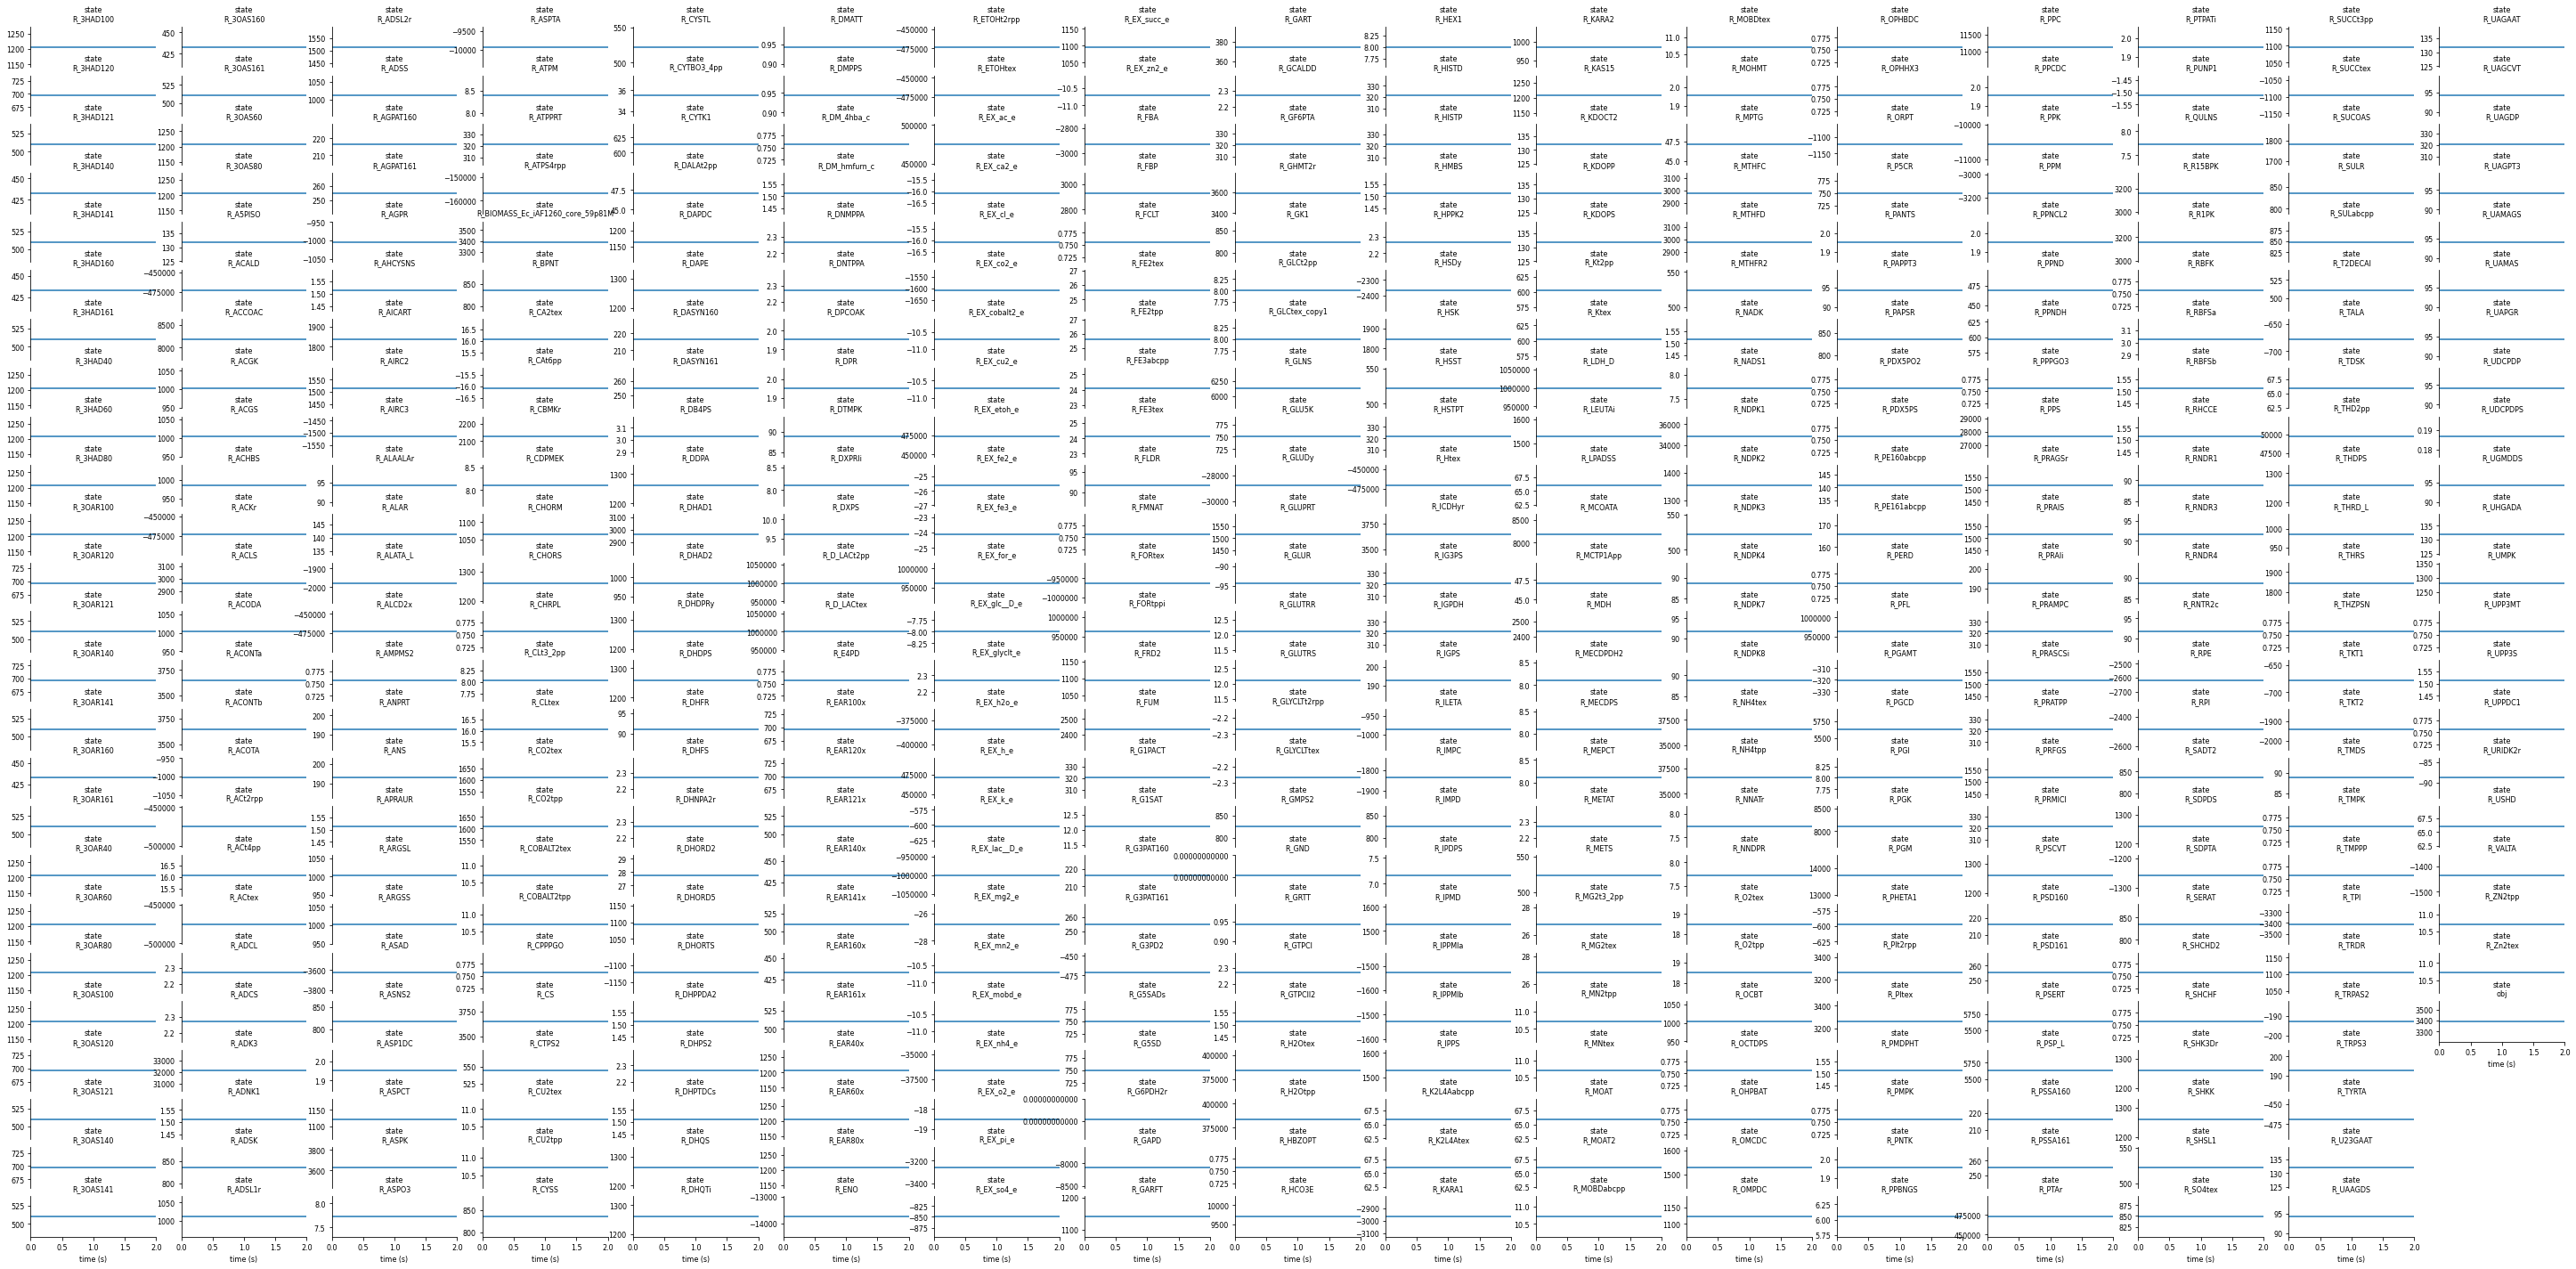

In [26]:
# get the data
fba_output = fba_experiment.emitter.get_timeseries()

settings = {'max_rows': 25}
fba_fig = plot_simulation_output(fba_output, settings)

## Flux Converter Process

In [29]:
from vivarium_biosimulators.processes.flux_bounds import FluxBoundsConverter

flux_ids = [rxn_id for rxn_id in FLUX_TO_BOUNDS_MAP.keys()]

# make the ode process
ode_config_2 = {
    'output_ports': {'fluxes': flux_ids},
    'emit_ports': ['outputs', 'fluxes'],
    **ode_config,
}
ode_process_2 = BiosimulatorProcess(ode_config_2)
        
# make the ode flux bounds converter process
flux_bounds_config = {
    'ode_process': ode_process_2,
    'flux_to_bound_map': FLUX_TO_BOUNDS_MAP,
    'flux_unit': 'mol/L',
    'bounds_unit': 'mmol/L/s',
}
ode_flux_converter = FluxBoundsConverter(flux_bounds_config)

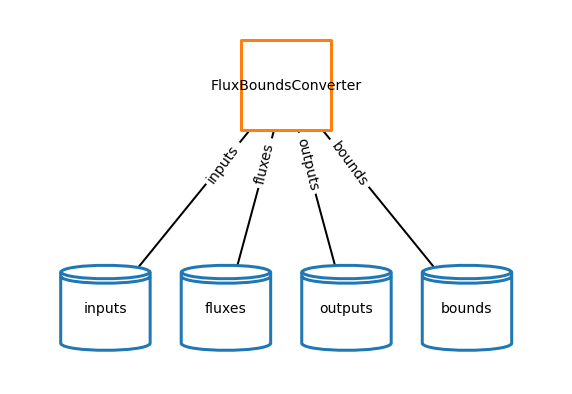

In [30]:
settings = {}
fba_topology = plot_topology(ode_flux_converter, settings)

## ODE_FBA Composite

In [ ]:
from vivarium_biosimulators.composites.ode_fba import ODE_FBA

In [32]:
# ode_fba configuration
config = {
    'ode_config': {
        'biosimulator_api': 'biosimulators_tellurium',
        'model_source': SBML_MODEL_PATH,
        'simulation': 'uniform_time_course',
        'model_language': ModelLanguage.SBML.value,
        'algorithm': {
            'kisao_id': 'KISAO_0000019',
        }
    },
    'fba_config': {
        'biosimulator_api': 'biosimulators_cobrapy',
        'model_source': BIGG_MODEL_PATH,
        'simulation': 'steady_state',
        'model_language': ModelLanguage.SBML.value,
        'algorithm': {
            'kisao_id': 'KISAO_0000437',
        }
    },
    'flux_to_bound_map': FLUX_TO_BOUNDS_MAP,
    'flux_unit': 'mol/L',
    'bounds_unit': 'mmol/L/s',
    # 'bounds_unit': 'mmol/g/hr',
    'default_store_name': 'state',
}
ode_fba_composer = ODE_FBA(config)

In [35]:
# get initial state from composer
initial_state = ode_fba_composer.initial_state()
initial_state['bounds']['R_EX_glc__D_e_lower_bound'] = -2.0

# generate the composite
ode_fba_composite = ode_fba_composer.generate()

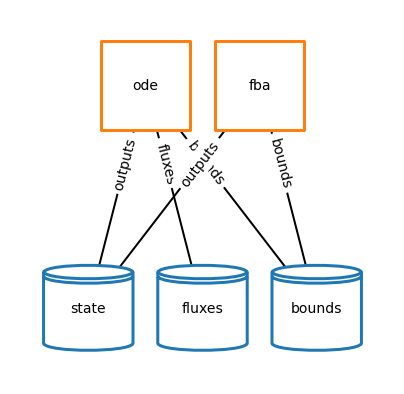

In [36]:
settings = {}
ode_fba_topology = plot_topology(ode_fba_composite, settings)